In [1]:
# TODO:
# Try a set of channels instead of mean
# Try different sequence durations
# Try different PIL
# Normalize the segments
# Possibly data augumentation
#
# GRAD-CAM
# data visualization
# hierarchical model
# standardization and normalization (either based on training or individually)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil
import os
import pickle
from scipy.io import loadmat
from scipy.signal import stft

In [2]:
# CNN class
# TODO: some hardcoded numbers
class CNN(nn.Module):
    def __init__(self, input_channels=1, conv_channels=(3, 10), kernel=(5, 5), dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, conv_channels[0], 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv_channels[0], conv_channels[1], 5)
        self.fc1 = nn.Linear(58*conv_channels[1], 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout1d = nn.Dropout(p=dropout)
        self.dropout2d = nn.Dropout2d(p=dropout)
        self.batchnorm1 = nn.BatchNorm2d(input_channels)
        self.batchnorm2 = nn.BatchNorm2d(conv_channels[0])

    def forward(self, x):
        x = self.batchnorm1(x)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        # x = self.dropout2d(x)
        x = self.batchnorm2(x)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        # x = self.dropout2d(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout1d(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
from swec_utils import training_model
def grid_search(epochs, device, weights, train_loader, val_loader, dtype, kernel_sizes, n_filters, dropouts, save_path, plot_results=False):
    sensitivity = []
    specificity = []
    auc = []
    f1 = []
    pr_auc = []
    for k in kernel_sizes:
        for f in n_filters:
            for d in dropouts:
                print(f"Training model with kernel size = {k}, filter_sizes = {f}, dropout = {d}.")
                model = CNN(input_channels=next(iter(train_loader))[0].shape[1], conv_channels=f, kernel=(k, k), dropout=d)
                model.to(numpy_to_torch_dtype_dict[dtype])
                t_res, v_res = training_model(model, epochs, device, weights, train_loader, val_loader, dtype, plot_results=plot_results)
                sensitivity.append(v_res.sen[-1])
                specificity.append(v_res.spe[-1])
                auc.append(v_res.auc[-1])
                f1.append(v_res.f1[-1])
                pr_auc.append(v_res.pr_auc[-1])
                if (save_path):
                    print("Saving model")
                    save_path += 'CNN_k' + str(k) + '_f' + str(f[0]) + '_' + str(f[1]) + '_d' + str(d).replace('.', '')
                    torch.save(model.state_dict(), save_path)
    
    return sensitivity, specificity, auc, f1, pr_auc

In [4]:
def channel_selection(subject_path, seq_duration, sph, pil, distance, dtype, n_channels, **kwargs):
    seed = 0
    results_list = []
    for channel in range(n_channels):
        print(f"Channel {channel}.")
        segments, labels, fs = load_data(subject_path, seq_duration, sph, pil, distance, channels=[channel], dtype=dtype)

        segments_t = np.transpose(segments, (0, 2, 1))
        print(segments_t.shape)
        print(segments_t.dtype)
        Zxx = np.zeros((segments_t.shape[0], segments_t.shape[1], 129, 21), dtype=dtype)

        _, _, Zxx = stft(segments_t, fs=fs)

        BATCH = 512
        EPOCHS = 250
        use_cuda = True
        device = torch.device("cuda" if use_cuda else "cpu")

        X, X_test, Y, Y_test = train_test_split(Zxx, labels, test_size=0.2, stratify=labels, random_state=seed)

        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=seed)

        weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train), dtype=dtype, device=device)
        # weights = torch.tensor([1, 1], dtype=torch.float32, device=device)

        # convert dataset to Dataloader
        train_dataset = STFTDataset(X_train, Y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
        val_dataset = STFTDataset(X_val, Y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH)

        results = grid_search(EPOCHS, device, weights, train_loader, val_loader, dtype, **kwargs, save_path='')
        results_list.append(results)

    return results_list

In [5]:
def copy_subject(src, dst):
    src_files = os.listdir(src)
    for file_name in src_files:
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst)
            print(file_name)

subject = 'ID03'
src = 'D:/research/swec/' + subject
dst = '../swec/' + subject
data_path = '../swec/' + subject + '/data.p'
if (not os.path.exists(data_path)):
    if (len(os.listdir(dst)) == 0):
        copy_subject(src, dst)

In [6]:
# 1: 4
# 2: 7
# 3: 2
from swec_utils import load_data
subject_path = '../swec/' + subject + '/' + subject
seq_duration = 5
sph = 300
pil = 3600
distance = 3600 * 24 * 2

dtype = np.float16

if (os.path.exists(data_path)):
    print(f"Data already processed at {data_path}")
    data = pickle.load(open(data_path, 'rb'))
    Zxx, labels = data
else:
    segments, labels, fs = load_data(subject_path, seq_duration, sph, pil, distance, channels=[], dtype=dtype)

    segments_t = np.transpose(segments, (0, 2, 1))
    print(segments_t.shape)
    print(segments_t.dtype)
    Zxx = np.zeros((segments_t.shape[0], segments_t.shape[1], 129, 21), dtype=dtype)

    for i in range(segments_t.shape[1]):
        print(i)
        _, _, Zxx[:, i, :] = stft(segments_t[:,i,:], fs=fs)
    print(Zxx.shape)

    data = (Zxx, labels)
    pickle.dump(data, open(data_path, 'wb'))

Data already processed at ../swec/ID03/data.p


Training model with kernel size = 7, filter_sizes = (5, 5), dropout = 0.5.
Training:
	Loss: 17.0625
	Sensitivity: 0.8887683125339121
	Specificity: 0.822560742096081
	AUC: 0.9258981210044444
	F1 Score: 0.4281793229643184
	PR AUC: 0.5102058000881868
Validation:
	Loss: 4.487060546875
	Sensitivity: 0.9566160520607375
	Specificity: 0.7579574468085106
	AUC: 0.934423962708266
	F1 Score: 0.3795180722891566
	PR AUC: 0.509298163780513


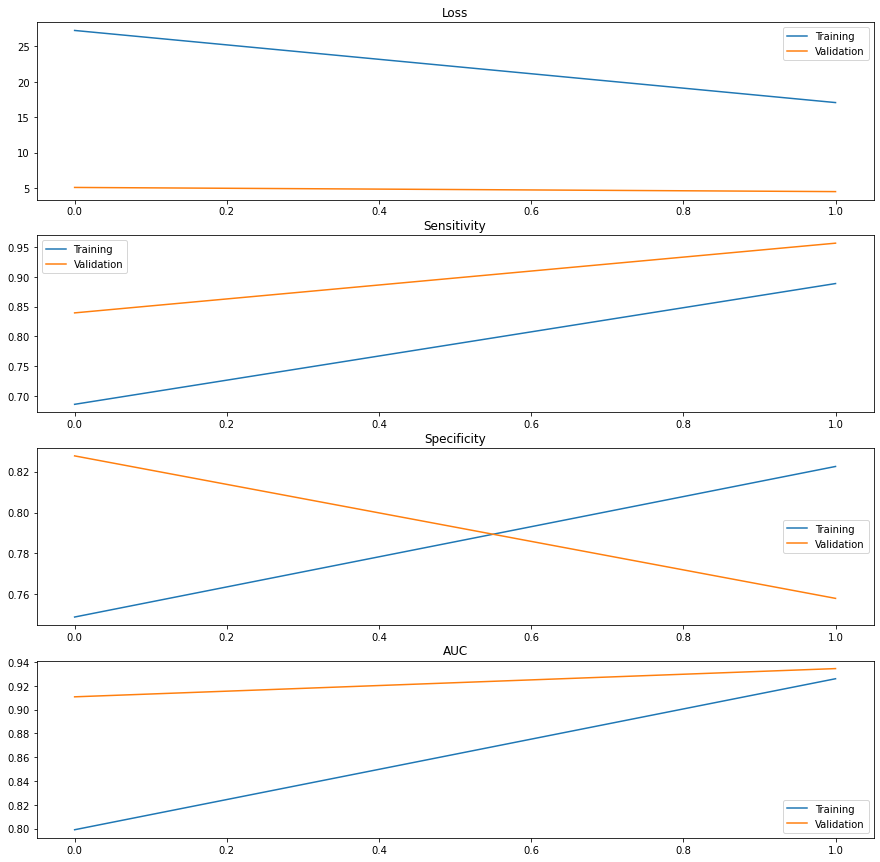

In [7]:
from swec_utils import STFTDataset, numpy_to_torch_dtype_dict
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

BATCH = 512
EPOCHS = 2
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

X, X_test, Y, Y_test = train_test_split(Zxx, labels, test_size=0.2, stratify=labels, random_state=0)

del Zxx, labels

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

del X, Y

weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train), dtype=numpy_to_torch_dtype_dict[dtype], device=device)

# convert dataset to Dataloader
train_dataset = STFTDataset(X_train, Y_train, dtype=dtype)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
val_dataset = STFTDataset(X_val, Y_val, dtype=dtype)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH)

save_path = 'models/swec/' + subject + '/'
save_path = ''
results = grid_search(EPOCHS, device, weights, train_loader, val_loader, dtype, [7], [(5, 5)], [0.5], save_path=save_path, plot_results=True)

In [8]:
from swec_utils import to_numpy

# convert dataset to Dataloader
test_dataset = STFTDataset(X_test, Y_test, dtype=dtype)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

# retrieve model from save
model = CNN(input_channels=next(iter(test_loader))[0].shape[1], kernel=(7, 7), conv_channels=(5, 5), dropout=0.5)
path = './models/swec/' + subject + '/CNN_k7_f5_5_d05'
model.load_state_dict(torch.load(path))

model.to(numpy_to_torch_dtype_dict[dtype])
model.to(device)
model.eval()

pred_list = np.zeros((len(test_loader.dataset), 2))
true_list = np.zeros(len(test_loader.dataset))
i = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        pred_list[i:i+len(data)] = to_numpy(output)
        true_list[i:i+len(data)] = to_numpy(target)
        i += len(data)

y_true = true_list
y_pred = pred_list

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix, auc, average_precision_score, plot_precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
from swec_utils import evaluate_performance

print(y_true.shape)
print(y_pred.shape)

sensitivity, specificity, roc_auc, f1_score, pr_auc = evaluate_performance(y_pred, y_true)

print("Sensitivity: " + str(sensitivity))
print("Specificity: " + str(specificity))
print("F1 Score: " + str(f1_score))
print("AUC: " + str(roc_auc))
print("PR AUC: " + str(pr_auc))

(7920,)
(7920, 2)
Sensitivity: 0.9236111111111112
Specificity: 0.9895152505446623
F1 Score: 0.8978902953586498
AUC: 0.994097600459937
PR AUC: 0.9484664272905107


In [10]:
print(X_val[0,:,0])
print(X_val[0,:,-1])
print(X_val[-1,:,0])
print(X_val[-1,:,-1])
print(np.count_nonzero(Y_val == 1))

[[  0.988   16.34   -21.84   ...  37.34    -3.68   -15.29  ]
 [ -9.44    57.78   -17.05   ...  -5.93    -0.6284 -14.836 ]
 [-12.36    25.86     3.166  ...   4.414   -0.3167 -16.02  ]
 ...
 [ -3.797   43.9     -6.848  ... -11.445  -21.38    17.77  ]
 [-11.016   26.75    14.62   ...   1.908  -23.77     7.527 ]
 [-10.63    17.4     -6.414  ...  24.7    -27.86     3.205 ]]
[[-1.116e-01 -1.853e-04  5.794e-05 ... -4.295e-03  4.210e-04  1.746e-01]
 [-1.301e-01  1.699e-03  4.706e-04 ... -2.220e-04  4.833e-04  1.359e-01]
 [-1.001e-01  3.642e-05  9.209e-05 ... -5.217e-04 -1.694e-04  2.225e-01]
 ...
 [-2.209e-01 -6.490e-04 -7.689e-06 ...  2.325e-04 -1.233e-04 -1.970e-01]
 [-3.499e-01 -9.851e-04  1.098e-03 ...  3.655e-04 -1.273e-03 -2.343e-01]
 [-2.493e-01  3.164e-04  2.067e-04 ... -9.098e-04 -9.918e-04 -7.043e-02]]
[[-0.87    1.188  -3.086  ... -2.9    -0.6772  0.696 ]
 [ 1.65   -1.995  -3.168  ... -1.017   1.211  -0.4421]
 [ 2.23   -0.729   0.622  ... -2.027   1.232  -0.1957]
 ...
 [-0.848   2.3

In [11]:
print(X_val[np.where(Y_val == 1)[0][0],:,0])
print(X_val[np.where(Y_val == 1)[0][0],:,-1])

[[ 9.3906e+00  7.7500e+00 -3.6719e+01 ...  1.4328e+01  1.8188e+01
   5.6289e+00]
 [ 4.2188e+00  9.8828e+00 -7.3398e+00 ...  4.7656e+01  5.2148e+00
  -2.8562e+01]
 [ 3.9648e+00 -3.0508e+00 -6.4414e+00 ...  8.8828e+00 -5.3027e-01
  -1.5086e+01]
 ...
 [-9.8047e+00  2.0156e+01 -4.0438e+01 ... -3.5137e+00 -5.5234e+00
   5.2094e-02]
 [-2.2062e+01  2.5594e+01  1.1055e+01 ...  1.5188e+01 -9.4766e+00
   7.7266e+00]
 [ 1.9326e+00  5.4188e+01  2.5531e+01 ... -4.4336e+00 -6.0273e+00
   1.4195e+01]]
[[ 1.527e-01 -1.231e-04 -8.769e-04 ... -7.033e-05 -4.001e-04  3.091e-02]
 [ 1.954e-01 -4.631e-05  2.596e-04 ...  1.808e-04 -6.003e-04  2.024e-01]
 [ 5.270e-02 -2.539e-04 -1.124e-03 ... -4.864e-04  1.333e-04  1.121e-01]
 ...
 [ 4.730e-02  1.020e-03 -4.969e-04 ...  6.413e-04  1.321e-03  6.378e-02]
 [-6.970e-02  4.201e-04 -5.717e-04 ...  4.437e-04  6.781e-04 -7.697e-02]
 [-1.571e-01 -1.250e-03 -6.394e-04 ...  1.786e-04  4.125e-04 -1.810e-01]]
